# Ebay listings visualizer

Visualize the spread of listings on Ebay.

In [1]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#search = 'razer blade 15 2070'
search = input()
search.replace(' ', '+')

'razer+blade+15+2070'

In [3]:
URL = 'https://www.ebay.com/sch/i.html?_from=R40&_nkw='
modifier = '&_sacat=0&LH_TitleDesc=0&_ipg=200'

In [4]:
page = requests.get(URL + search + modifier)

In [5]:
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all('li', {'class': 's-item s-item--watch-at-corner'})

In [6]:
names, prices = [], []
counter = 0

for result in results:
    
    # filter bids
    if result.find('span', {'class': 's-item__bids s-item__bidCount'}) is not None: continue
        
    name = result.find('h3', {'class': 's-item__title'}).get_text()
    price = result.find('span', {'class': 's-item__price'}).get_text()
    if 'see price' in price.lower(): continue
    print(name)
    print(price)
    names.append(name)
    
    for ch in [',', '$']:
        if ch in price:
            price = price.replace(ch, '')
            
    prices.append(float(price))
    counter = counter + 1
    
print('\nTotal results:', counter)

RB Razer Blade 15 15.6" 300Hz Intel i7-10875H Nvidia RTX 2070 Super 512GB SSD
$1,829.99
Razer Blade 15 - 15.6" Full HD Intel Core i7 16GB RAM 512GB SSD RTX 2070
$1,300.00
NEW Razer Blade 15 15.6" 240Hz Intel i7-9750H Nvidia RTX 2070 512GB SSD Laptop
$1,699.99
Mercury White Razer Blade 15: Intel i7-9750H; NVIDIA GeForce RTX 2070
$1,499.00
Razer Blade 15 (2019) Advanced i7-9750H RTX 2070 Max-Q 240Hz + 2 Years RazerCare
$1,749.99
Razer Blade 15 - 300Hz - Intel i7-10875H - RTX 2070 Super - 16GB Ram - 512GB SSD
$1,789.99
OB Razer Blade 15 15.6" 240Hz Intel i7-9750H Nvidia RTX 2070 512GB SSD Laptop
$1,649.99
Razer Blade 15 Advanced Gaming Intel i7-8750H 144Hz 256 GB SSD RTX 2070
$1,499.99
Razer Blade 15 Base - 15.6" 4K OLED - i7 10th - RTX 2070 Max-Q - 16GB RAM 512GB
$1,800.00
Razor Blade 15 2070 Max-Q Core i7 9750H 16GB RAM 512GB SSD 15.6in Mercury
$1,500.00
Razer Blade 15 i7-9750H 2.6GHz 16GB 512GB GeForce RTX 2070 Max-Q Mercury White
$1,725.00
Razer Blade 15 15.6" 240Hz Intel i7-9750H Nvi

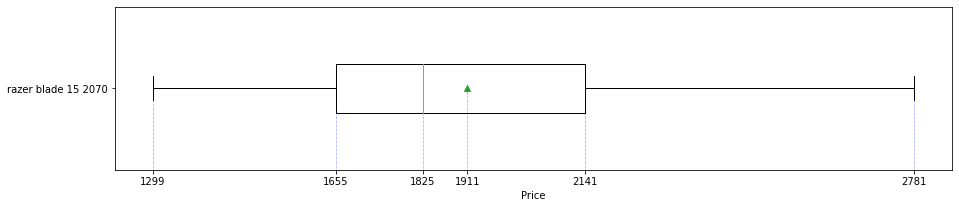

In [7]:
df = pd.DataFrame(
    {'Price': prices
    })

# remove outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = df[((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

# boxplot
fig = plt.figure(1, figsize=(15, 3))
ax = fig.add_subplot(111)
bp = ax.boxplot(df, showmeans=True, manage_ticks=True, vert=False)

ax.set_xlabel('Price')
ax.set_yticks([1])
ax.set_yticklabels([search])

# recalculate quantiles
quantiles = np.quantile(df, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
quantiles = np.append(quantiles, df.mean()[0])
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size, color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.75, 1.25)
ax.set_xticks(quantiles)
plt.show()

In [8]:
df.describe()

,Price
count,62.000000
mean,1911.366774
std,372.656151
min,1299.000000
25%,1654.742500
50%,1824.990000
75%,2141.247500
max,2780.990000


In [9]:
outliers

,Price
38,3000.00
58,3409.99
59,3741.86


In [10]:
def get_threshold(search):
    '''Returns thresholds from file given search query'''

    with open ('data/thresholds.txt') as f:
        for line in f:
            if search in line:
                threshold_lo = int(f.readline())
                threshold_hi = int(f.readline())
                break
    return threshold_lo, threshold_hi

In [11]:
thresholds=(float('-inf'), float('inf'))
thresholds = (800, 3000)

# initialize lists
prices, price_ints, names, links, badwords = [], [], [], [], []

# get bad words
f = open('data/avoid_keywords.txt')
for line in f:
    badwords.append(line.strip())
f.close()


num_pages = 1
counter = 0

for i in range(num_pages):
    
    URL = 'https://losangeles.craigslist.org/search/sss?query='
    #search = 'razer+blade+15'
    sortby = '&sort=rel'
    if i > 0:
        pgnum = 's=' + str(i * 120) + '&'
    else:
        pgnum = ''
    page = requests.get(URL + pgnum + search + sortby)

    # get soup
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all('li', {'class': 'result-row'})

    for result in results:

        # price of individual post
        price = result.find('span', {'class': 'result-meta'}).find('span', {'class': 'result-price'}).get_text()

        # strint to int
        if len(price) == 1: continue
        price_int = int(price.replace(',','')[1:])

        # filter by threshold
        if price_int < thresholds[0] or price_int > thresholds[1] or price_int == 0: continue

        # name
        name = result.find('h3', {'class': 'result-heading'}).find('a').get_text()
        if len(name) == 0: continue

        # filter by bad words
        if any(badkw in name.lower() for badkw in badwords):
            continue

        # link
        link = result.find('a').get('href')
        if len(link) <= 0: continue

        # add result to list
        names.append(name)
        prices.append(price)
        price_ints.append(price_int)
        links.append(link)
        
        counter = counter + 1


for i in range(len(prices)):
    print(names[i])
    print(prices[i])
    #print(links[i])

print(counter)

2020 Razer Blade 15 Advanced
$2,800
Razer - Blade 15.6" 4K Ultra HD Gaming Laptop - Intel Core i7 - 16GB Memory
$1,700
2


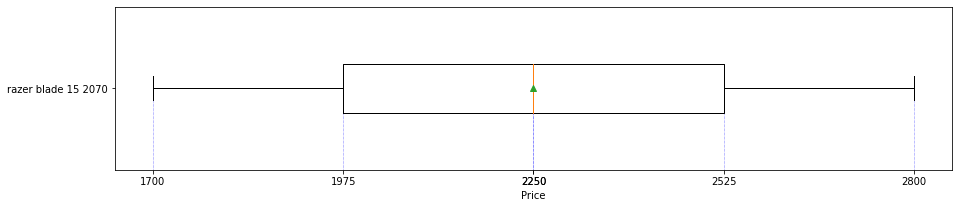

In [12]:
df_cg = pd.DataFrame(
    {'Price': price_ints
    })

# remove outliers
Q1 = df_cg.quantile(0.25)
Q3 = df_cg.quantile(0.75)
IQR = Q3 - Q1
outliers = df_cg[((df_cg < (Q1 - 1.5 * IQR)) |(df_cg > (Q3 + 1.5 * IQR))).any(axis=1)]
df_cg = df_cg[~((df_cg < (Q1 - 1.5 * IQR)) |(df_cg > (Q3 + 1.5 * IQR))).any(axis=1)]

# boxplot
fig = plt.figure(1, figsize=(15, 3))
ax = fig.add_subplot(111)
bp = ax.boxplot(df_cg, showmeans=True, manage_ticks=True, vert=False)

ax.set_xlabel('Price')
ax.set_yticks([1])
ax.set_yticklabels([search])

# recalculate quantiles
quantiles = np.quantile(df_cg, np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
quantiles = np.append(quantiles, df_cg.mean()[0])
ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size, color='b', ls=':', lw=0.5, zorder=0)
ax.set_ylim(0.75, 1.25)
ax.set_xticks(quantiles)
plt.show()

In [13]:
df_cg.describe()

,Price
count,2.000000
mean,2250.000000
std,777.817459
min,1700.000000
25%,1975.000000
50%,2250.000000
75%,2525.000000
max,2800.000000


In [14]:
outliers

,Price


In [15]:
save = df.mean()[0] - df_cg.mean()[0]
print('Average savings on craigslist vs ebay:', save)
print('Percent savings: ', save / df.mean()[0] * 100)

Average savings on craigslist vs ebay: -338.63322580645126
Percent savings:  -17.716810314929155
